## DTSA5511  - CNN Cancer Detection Kaggle 
### Author - Korkrid Akepanidtaworn, University of Colorado Boulder, Masters in Data Science
### Date - August, 20,2024

## Project Goal

- I am tackling a binary image classification task to detect metastases in 96 x 96px digital histopathology images. A significant challenge is identifying metastases as small as single cells within a vast tissue area.
- The performance is measured by the area under the ROC curve, which assesses the classifier's ability to distinguish between positive and negative instances. An ideal outcome would achieve an AUC of 1, indicating perfect classification with no false positives.
- [Histopathologic Cancer Detection | Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

## Dataset Description

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The ``train_labels.csv`` file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

In [1]:
# Check Python version
!python --version

Python 3.10.13


In [22]:
# Install necessary packages in a single command
!pip install pandas numpy matplotlib scikit-learn keras tensorflow scikit-image

In [26]:
# Import Python library
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.src.legacy.preprocessing.image import ImageDataGenerator
from skimage import io
import cv2
import tensorflow as tf

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/opt/conda/lib/python3.10/site-packages/keras/api/preprocessing/image/__init__.py)

In [3]:
# List all the files in the specified directory
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [4]:
# Print how many images are there in each of the folder in the train and test set.
print(f'{len(os.listdir("../input/histopathologic-cancer-detection/train"))} pictures in train.')
print(f'{len(os.listdir("../input/histopathologic-cancer-detection/test"))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


In [5]:
# Read "train_labels" data
df_train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(df_train_labels.shape)

(220025, 2)


In [6]:
# Show the first 10 rows in the "train_labels" data
df_train_labels.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


## EDA Procedure

In [7]:
def draw_category_images(col_name, figure_cols, df, IMAGE_PATH):
    """
    Author: Korkrid Kyle Akepanidtaworn, MSDS 
    Displays a sample of images for each category in a specified column of a DataFrame.
    
    Parameters:
    - col_name (str): The name of the column containing category labels.
    - figure_cols (int): The number of columns in the output figure (i.e., number of images per row).
    - df (pd.DataFrame): The DataFrame containing image metadata.
    - IMAGE_PATH (str): The directory path where images are stored.
    
    The function displays a row of sample images for each category. Each row contains a 
    random sample of images from that category. Due to the random sampling, the images 
    displayed will vary each time the function is run.
    """
    
    # Get unique categories from the specified column
    categories = df[col_name].unique()
    
    # Create a subplot for each category with the specified number of columns
    fig, ax = plt.subplots(nrows=len(categories), ncols=figure_cols, 
                           figsize=(4 * figure_cols, 4 * len(categories)))
    
    # Ensure ax is a 2D array for easy indexing
    if len(categories) == 1:
        ax = np.expand_dims(ax, axis=0)
    
    # Iterate over each category to display images
    for i, cat in enumerate(categories):
        # Sample a fixed number of images for the current category
        sample = df[df[col_name] == cat].sample(figure_cols)
        
        # Display each image in the subplot
        for j in range(figure_cols):
            # Construct the file path for the image
            file = IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            
            # Read the image using OpenCV
            im = cv2.imread(file)
            
            # Display the image in the subplot
            ax[i, j].imshow(im, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)
            ax[i, j].axis('off')  # Hide axis labels for a cleaner look
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the figure
    plt.show()

For each run, it displays different images due to the random sampling.

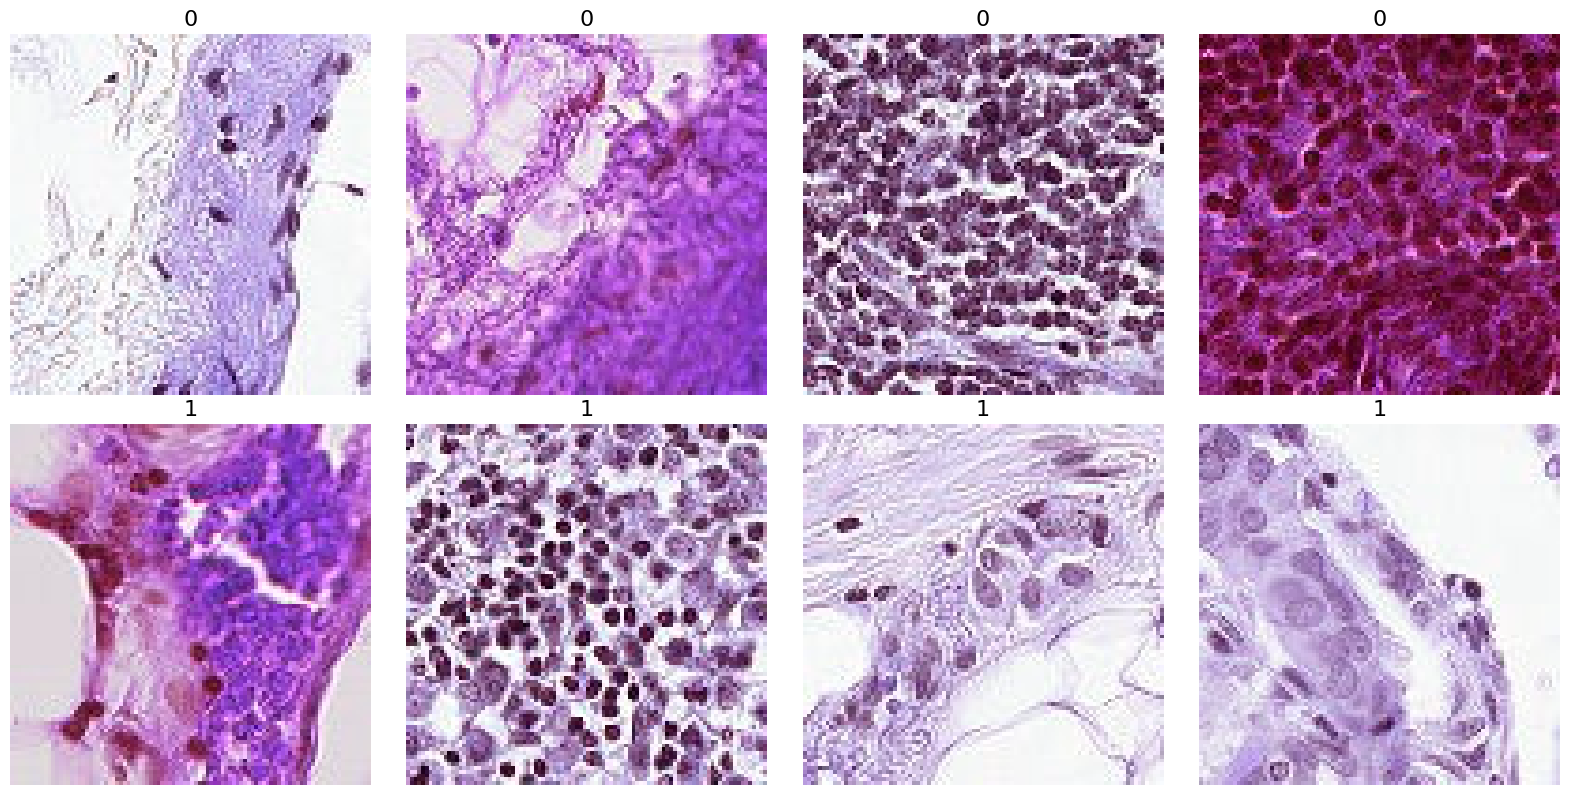

In [8]:
IMAGE_PATH_TRAIN = '../input/histopathologic-cancer-detection/train/' 

# Let's give it a try
draw_category_images('label',4, df_train_labels, IMAGE_PATH_TRAIN)

Next, I examine the distribution of cancerous versus non-cancerous cases. The dataset shows a slight imbalance, with class 0 having a significantly larger number of samples (130,908) compared to class 1 (89,117). Such an imbalance could potentially influence the performance of machine learning models, making them more inclined to favor the majority class. For the moment, my goal is to create a machine learning system that can accurately identify cancer in the given set of training images.

I will deal with the imbalanced problem later as I progress in this project.

- [Datasets: Imbalanced datasets  |  Machine Learning  |  Google for Developers](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets)
- [10 Techniques to handle imbalance class in Machine Learning](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)
- [what is an imbalanced dataset? Machine learning | Kaggle](https://www.kaggle.com/discussions/getting-started/100018)

In [9]:
df_train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

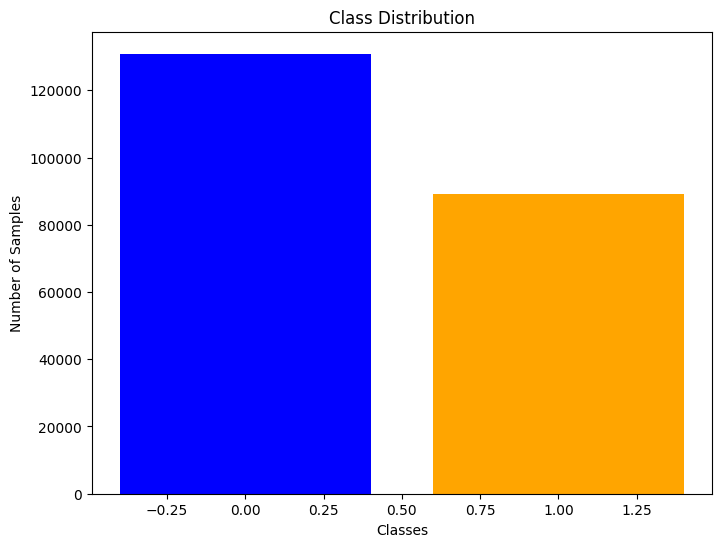

In [10]:
# Create a dataframe holder
eda_2 = df_train_labels['label'].value_counts().reset_index()

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(eda_2['label'], eda_2['count'], color=['blue', 'orange'])
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

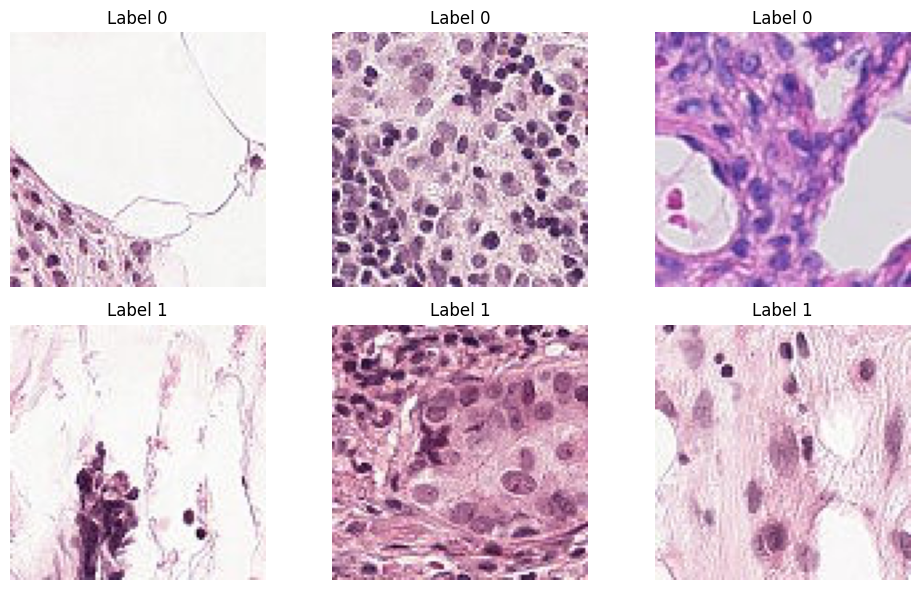

In [14]:
# Display a few sample images from each label category

num_images_to_display = 3

# Construct the full file path for each image
df_train_labels["path"] = "/kaggle/input/histopathologic-cancer-detection/train/" + df_train_labels["id"] + ".tif"

# Separate images by label
images_with_label_0 = df_train_labels[df_train_labels["label"] == 0]["path"].head(num_images_to_display)
images_with_label_1 = df_train_labels[df_train_labels["label"] == 1]["path"].head(num_images_to_display)

# Display the images
plt.figure(figsize=(10, 6))

for i, (img0, img1) in enumerate(zip(images_with_label_0, images_with_label_1)):
    # Label 0 (No Tumor)
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(plt.imread(img0))
    plt.axis('off')
    plt.title("Label 0")

    # Label 1 (Tumor)
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(plt.imread(img1))
    plt.axis('off')
    plt.title("Label 1")

plt.tight_layout()
plt.show()

In [16]:
# Select a random sample of 1000 image paths
sample_paths = df_train_labels["path"].sample(1000, random_state=1234)

# Check dimensions for the sampled images
unique_dimensions = {io.imread(path).shape for path in sample_paths}

# Print the unique dimensions found in the sample
if len(unique_dimensions) == 1:
    image_height, image_width, image_channels = unique_dimensions.pop()
    print(f"All sampled images have consistent dimensions: {image_height}x{image_width} pixels with {image_channels} channels.")
else:
    print(f"Unique dimensions found: {unique_dimensions}")

NameError: name 'io' is not defined